In [ ]:
!pip install ampligraph


  Using cached importlib_metadata-4.2.0-py3-none-any.whl (16 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.9.0
    Uninstalling importlib-metadata-4.9.0:
      Successfully uninstalled importlib-metadata-4.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.


In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

Found existing installation: tensorflow 1.13.2
Uninstalling tensorflow-1.13.2:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.13.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.13.2

  Using cached tensorflow-1.13.2-cp37-cp37m-manylinux1_x86_64.whl (92.7 MB)
  Using cached importlib_metadata-4.9.0-py3-none-any.whl (17 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the foll

Some sanity check:

---
# Getting Started with AmpliGraph
---
In this tutorial we will demonstrate how to use the AmpliGraph library. 

Things we will cover:

1. Exploration of a graph dataset
2. Splitting graph datasets into train and test sets
3. Training a model
4. Model selection and hyper-parameter search 
5. Saving and restoring a model
6. Evaluating a model
7. Using link prediction to discover unknown relations
8. Visualizing embeddings using Tensorboard

---

## Requirements

A Python environment with the AmpliGraph library installed. Please follow [the install guide](http://docs.ampligraph.org/en/latest/install.html).



In [ ]:
import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

'1.4.0'

## 1. Dataset exploration

In [ ]:
import csv
X = pd.read_csv('/content/characters - Family tree include Grand Parents.csv', encoding= 'unicode_escape').to_numpy()
X[:5, ]

array([['Bernd Doppler', 'Parent of', 'Helge Doppler'],
       ['Bernd Doppler', 'married', 'Greta Doppler'],
       ['Bernd Doppler', 'Grand Parents of', 'Peter Doppler'],
       ['Bernd Doppler', 'Grand Parents of', 'Elisabeth Doppler'],
       ['Bernd Doppler', 'Grand Parents of', 'Franziska Doppler']],
      dtype=object)

Let's list the subject and object entities found in the dataset:

In [ ]:
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
print("entities count =", len(entities))
print(entities)

entities count = 30
['Agnes Nielsen' 'Aleksander Tiedemann' 'Bartosz Tiedemann'
 'Bernd Doppler' 'Charlotte Doppler' 'Claudia Tiedemann' 'Daniel Kahnwald'
 'Doris Tiedemann' 'Egon Tiedemann' 'Elisabeth Doppler'
 'Franziska Doppler' 'Greta Doppler' 'H.G. Tannhaus' 'Hannah Kahnwald'
 'Helge Doppler' 'Hermann Albers' 'Ines Kahnwald' 'Jana Nielsen'
 'Jonas Kahnwald' 'Katharina Nielsen' 'Mads Nielsen' 'Magnus Nielsen'
 'Martha Nielsen' 'Mikkel Nielsen' 'NOAH' 'Peter Doppler'
 'Regina Tiedemann' 'Silja' 'Tronte Nielsen' 'Ulrich Nielsen']


.. and all of the relationships that link them. Remember, these relationships only link *some* of the entities.

In [ ]:
relations = np.unique(X[:, 1])
print("relations count =", len(relations))
print(relations)

relations count = 6
['Child of' 'Grand Child of' 'Grand Parents of' 'Parent of' 'married'
 'siblings']


# 2. Defining train and test datasets

As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets. 

What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple. 

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.  

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=0.25)

Our data is now split into train/test sets. If we need to further divide into a validation dataset we can just repeat using the same procedure on the test set (and adjusting the split percentages). 

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (110, 3)
Test set size:  (36, 3)


---
# 3. Training a model 

AmpliGraph has implemented [several Knoweldge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model (with  default values), so lets import that:

In [ ]:
from ampligraph.latent_features import ComplEx

Lets go through the parameters to understand what's going on:

- **`k`** : the dimensionality of the embedding space
- **`eta`** ($\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple
- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-3 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=2$, i.e. l2 regularization. $\lambda$ = 1e-5, set via the *regularizer_params* kwarg. 

Now we can instantiate the model:


In [ ]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=500, 
                k=170, 
                eta=3,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':2, 'lambda':1e-5}, 
                verbose=True)

## Filtering negatives

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [ ]:
positives_filter = X

## Fitting the model

Once you run the next cell the model will train. 

On a modern laptop this should take ~3 minutes (although your mileage may vary, especially if you've changed any of the hyper-parameters above).

In [ ]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average ComplEx Loss:   0.056995: 100%|██████████| 500/500 [01:22<00:00,  6.07epoch/s]


---
# 5.  Saving and restoring a model

Before we go any further, let's save the best model found so that we can restore it in future.

In [ ]:
from ampligraph.latent_features import save_model, restore_model

In [ ]:
save_model(model, './best_model.pkl')

This will save the model in the ampligraph_tutorial directory as `best_model.pkl`.

And let's just double check that the model we restored has been fit:

In [ ]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


---
# 6. Evaluating a model

Now it's time to evaluate our model on the test set to see how well it's performing. 

For this we'll use the `evaluate_performance` function:

In [ ]:
from ampligraph.evaluation import evaluate_performance

And let's look at the arguments to this function:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.


## Running evaluation

In [ ]:
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 36/36 [00:00<00:00, 347.66it/s]


## Metrics

Let's compute some evaluate metrics and print them out.

We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions. 

- ***mrr_score***:  The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- ***hits_at_n_score***: The function computes how many elements of a vector of rankings ranks make it to the top n positions.


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.59
Hits@10: 0.93
Hits@3: 0.76
Hits@1: 0.39



The [Mean Reciprocal Rank (MRR)](http://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.mrr_score.html) is another popular metrics to assess the predictive power of a model.


# 7. Predicting New Links

Link prediction allows us to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste. 

In our case, we're going to see which of the following candidate statements (that we made up) are more likely to be true:


In [ ]:
X_unseen = np.array([
    ['Bartosz Tiedemann', 'Grand Parents of', 'Ulrich Nielsen'], 
    ['Jonas Kahnwald', 'Grand Parents of', 'Agnes Nielsen'],
    ['Ines Kahnwald','Grand Parents of','Jonas Kahnwald'],
    ['Bartosz Tiedemann','Grand Parents of','Tronte Nielsen'],
    ['Silja','Grand Parents of','Tronte Nielsen'],
    ['Jonas Kahnwald','siblings','Ulrich Nielsen'],
     ['Jonas Kahnwald','Grand Child of','Martha Nielsen'],
     ['Regina Tiedemann','siblings','Hannah Kahnwald'],
     ['Mikkel Nielsen','Parent of','Bartosz Tiedemann'],
     ['Bartosz Tiedemann','Grand Parents of','Franziska Doppler']
])

In [ ]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [ ]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

100%|██████████| 10/10 [00:00<00:00, 133.16it/s]


In [ ]:
scores = model.predict(X_unseen)

We transform the scores (real numbers) into probabilities (bound between 0 and 1) using the expit transform.

Note that the probabilities are not calibrated in any sense. 

Advanced note: To calibrate the probabilities, one may use a procedure such as [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) or [Isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression). The challenge is to define what is a true triple and what is a false one, as the calibration of the probability of a triple being true depends on the base rate of positives and negatives.

In [ ]:
from scipy.special import expit
probs = expit(scores)

In [ ]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob'])

,statement,rank,score,prob
0,Bartosz Tiedemann Grand Parents of Ulrich Nielsen,46,-1.801045,0.141724
1,Jonas Kahnwald Grand Parents of Agnes Nielsen,20,0.052254,0.513061
2,Ines Kahnwald Grand Parents of Jonas Kahnwald,10,0.771304,0.683803
3,Bartosz Tiedemann Grand Parents of Tronte Nielsen,15,0.538449,0.631452
4,Silja Grand Parents of Tronte Nielsen,6,1.666999,0.841175
5,Jonas Kahnwald siblings Ulrich Nielsen,15,0.094109,0.523510
6,Jonas Kahnwald Grand Child of Martha Nielsen,32,-0.196524,0.451026
7,Regina Tiedemann siblings Hannah Kahnwald,16,-0.075653,0.481096
8,Mikkel Nielsen Parent of Bartosz Tiedemann,45,-0.955111,0.277858
9,Bartosz Tiedemann Grand Parents of Franziska D...,30,-0.490778,0.379710


In [ ]:
#df.to_csv('output.csv',index=False, head=True)

In [ ]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
0,Bartosz Tiedemann Grand Parents of Ulrich Nielsen,46,-1.801045,0.141724
8,Mikkel Nielsen Parent of Bartosz Tiedemann,45,-0.955111,0.277858
9,Bartosz Tiedemann Grand Parents of Franziska D...,30,-0.490778,0.379710
6,Jonas Kahnwald Grand Child of Martha Nielsen,32,-0.196524,0.451026
7,Regina Tiedemann siblings Hannah Kahnwald,16,-0.075653,0.481096
1,Jonas Kahnwald Grand Parents of Agnes Nielsen,20,0.052254,0.513061
5,Jonas Kahnwald siblings Ulrich Nielsen,15,0.094109,0.523510
3,Bartosz Tiedemann Grand Parents of Tronte Nielsen,15,0.538449,0.631452
2,Ines Kahnwald Grand Parents of Jonas Kahnwald,10,0.771304,0.683803
4,Silja Grand Parents of Tronte Nielsen,6,1.666999,0.841175


---
# 8. Visualizing Embeddings by Gephi

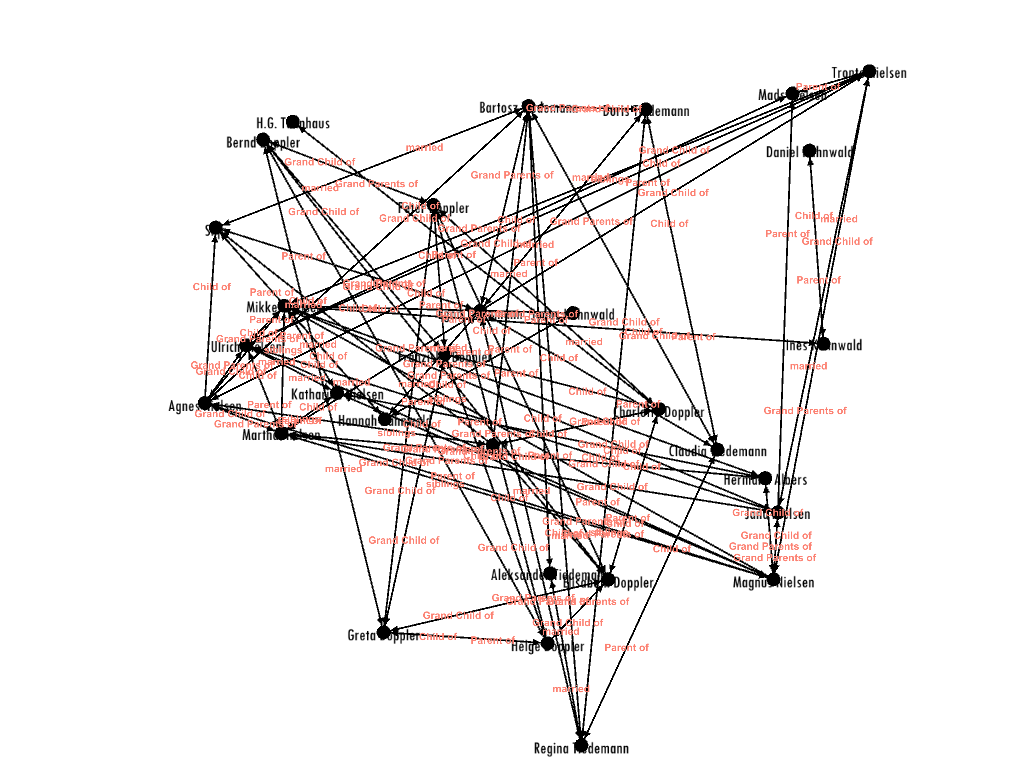